In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras.utils import plot_model

2023-09-23 04:41:40.612078: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Prepare the data

In [2]:
# Dataset Parameters
root = './dataset/'
batch_size = 88
img_height = 256
img_width = 256
seed = np.random.randint(0, 128)

In [3]:
# importing the training split
train_ds = keras.utils.image_dataset_from_directory(
  root + 'train/',
  validation_split=None,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15928 files belonging to 23 classes.


2023-09-23 04:42:09.872726: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-23 04:42:10.034952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-23 04:42:10.034992: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-23 04:42:10.037338: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-23 04:42:10.037377: I tensorflow/compile

In [4]:
# importing the validation split
val_ds = keras.utils.image_dataset_from_directory(
  root + 'test/',
  validation_split=None,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4228 files belonging to 23 classes.


# Hyperparameter initialisation and Dataset finalization

In [5]:
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 15
image_size = 56  # We'll resize input images to this size
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


In [6]:
# testing for class names presence
class_names = train_ds.class_names
print(class_names)
print(len(class_names))

['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Healthy', 'Herpes HPV and other STDs Photos', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']
23


In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(88, 256, 256, 3)
(88,)


In [8]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds


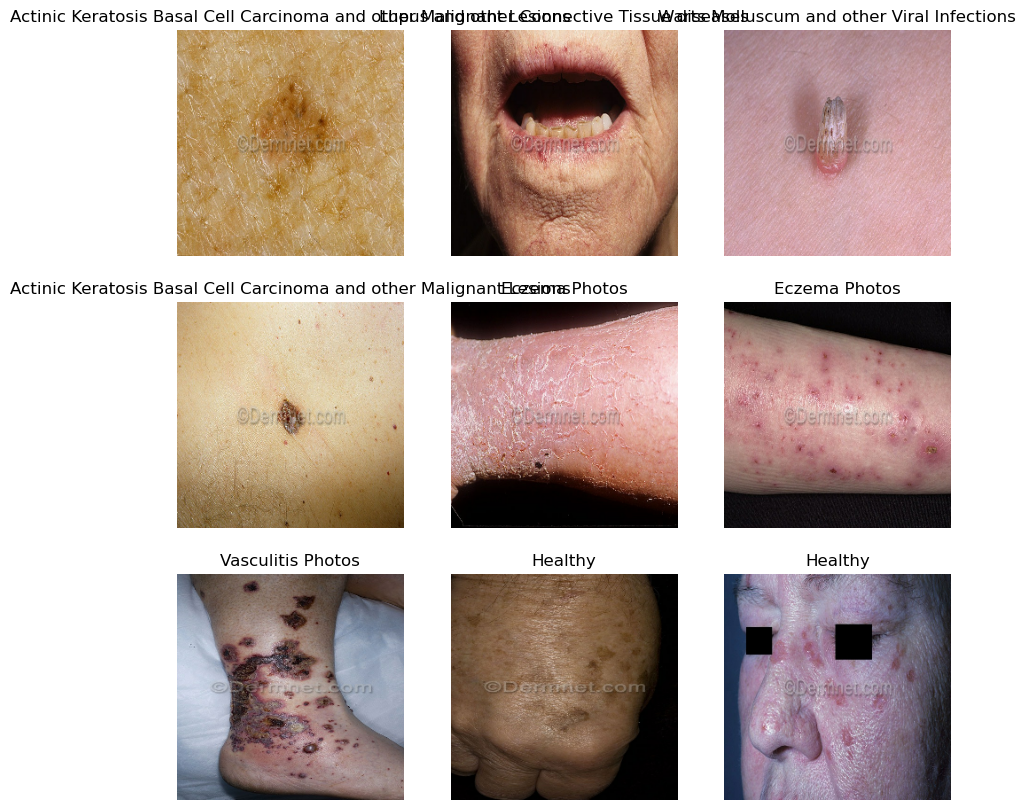

In [9]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [10]:
%reload_ext tensorboard
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [11]:
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def __init__(self, val=True):
        super().__init__()
        self.val = val
        
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(20,10))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if self.val:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_'+metric], 
                            label='validation '+metric)
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

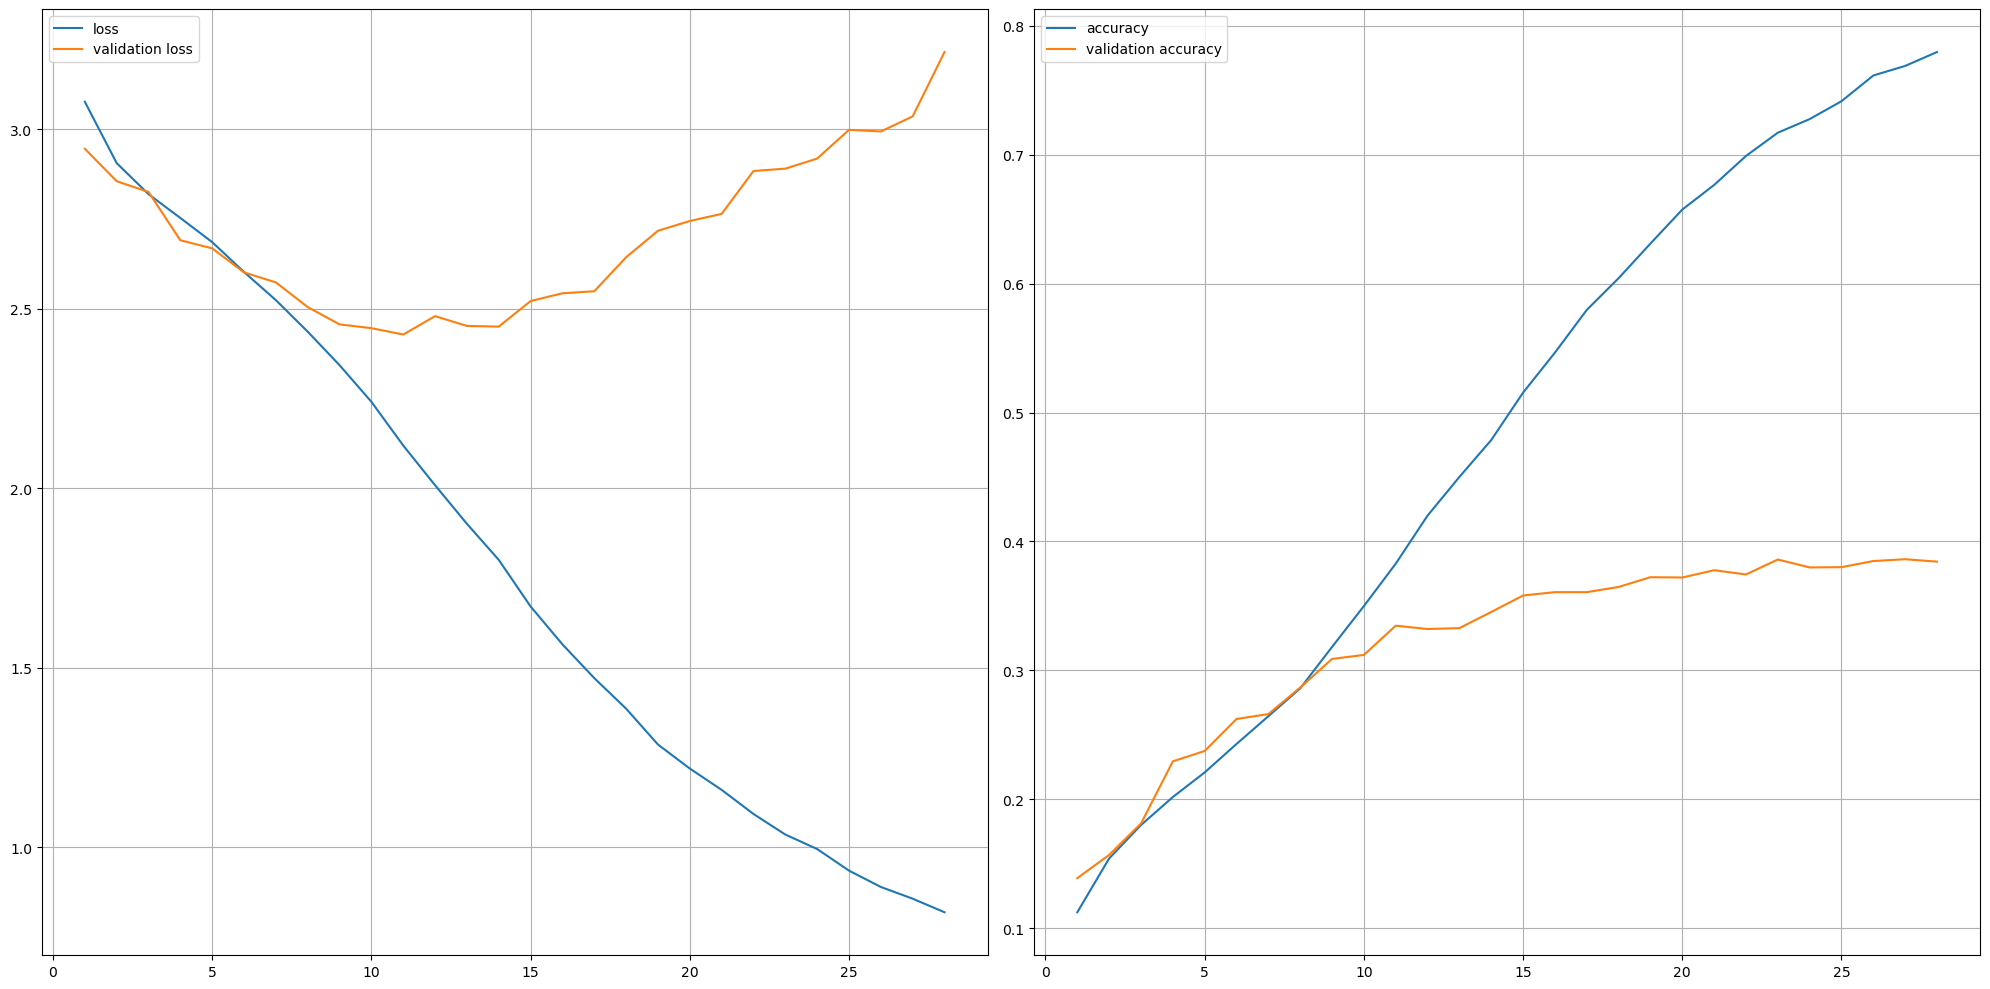

181/181 [==============================] - 33s 178ms/step - loss: 0.8196 - accuracy: 0.7798 - val_loss: 3.2157 - val_accuracy: 0.3843
Epoch 29/50
  1/181 [..............................] - ETA: 4:07 - loss: 0.9066 - accuracy: 0.7159

KeyboardInterrupt: 

In [12]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(8, 5, (1, 1), activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer='l2'),
  layers.MaxPooling2D((3, 3)),
  layers.Conv2D(8, 5, (2, 2), activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer='l2'),
  layers.Conv2D(16, 5, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer='l2'),
  # layers.Conv2D(36, 3, (2, 2), activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
  # layers.MaxPooling2D((3, 3)),
  layers.Flatten(),
  layers.Dropout(0.2),
  # layers.Dense(96 * num_classes, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
  layers.Dense(24 * num_classes, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(6 * num_classes, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
  layers.Dropout(0.2),
  layers.Dense(num_classes, activation='softmax')
])

model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.0005),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

fit = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50,
  callbacks=[tensorboard_callback, PlotLearning(val=True)]
)

In [13]:
model.evaluate(val_ds, callbacks=[tensorboard_callback])

49/49 [==============================] - 7s 121ms/step - loss: 3.2166 - accuracy: 0.3912


[3.216641426086426, 0.39120152592658997]

In [25]:
images = []
labels = []

for x, y in val_ds.unbatch().take(1150):
    images.append(x)
    labels.append(np.array(y).item())

In [26]:
model.save('./models/cnn-' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.keras')

In [27]:
test = np.array(images)

In [28]:
y_pred = (model.predict(test)).argmax(axis=1)

36/36 [==============================] - 0s 10ms/step


In [29]:
y_pred

array([ 7, 18,  1, ...,  5,  5,  6])

In [30]:
labels

[12,
 5,
 2,
 0,
 21,
 7,
 0,
 4,
 22,
 12,
 12,
 22,
 12,
 20,
 17,
 19,
 15,
 16,
 2,
 18,
 14,
 4,
 5,
 17,
 17,
 4,
 9,
 16,
 14,
 5,
 7,
 5,
 3,
 16,
 5,
 0,
 15,
 14,
 14,
 8,
 5,
 5,
 5,
 8,
 14,
 14,
 5,
 12,
 11,
 1,
 8,
 18,
 14,
 5,
 5,
 11,
 18,
 14,
 0,
 8,
 22,
 14,
 16,
 22,
 0,
 11,
 1,
 17,
 17,
 1,
 22,
 20,
 14,
 16,
 7,
 16,
 13,
 5,
 1,
 14,
 12,
 20,
 2,
 18,
 10,
 10,
 19,
 18,
 14,
 14,
 3,
 15,
 22,
 2,
 3,
 10,
 18,
 5,
 10,
 11,
 9,
 1,
 1,
 12,
 16,
 16,
 8,
 7,
 11,
 5,
 21,
 17,
 5,
 7,
 17,
 22,
 17,
 12,
 14,
 14,
 8,
 0,
 22,
 8,
 14,
 4,
 18,
 18,
 8,
 2,
 9,
 5,
 2,
 16,
 11,
 9,
 21,
 16,
 22,
 0,
 13,
 8,
 18,
 22,
 8,
 8,
 20,
 18,
 4,
 14,
 6,
 5,
 14,
 8,
 17,
 12,
 8,
 16,
 22,
 10,
 22,
 18,
 22,
 12,
 22,
 21,
 22,
 1,
 18,
 8,
 18,
 16,
 0,
 16,
 5,
 9,
 5,
 22,
 8,
 22,
 11,
 5,
 16,
 11,
 8,
 18,
 11,
 14,
 0,
 2,
 4,
 20,
 8,
 0,
 8,
 8,
 22,
 6,
 7,
 11,
 14,
 2,
 13,
 15,
 8,
 12,
 14,
 3,
 13,
 0,
 14,
 10,
 11,
 9,
 16,
 1,
 5,
 4,
 0,

In [31]:
from sklearn.metrics import confusion_matrix, classification_report
print("==============TEST RESULTS============")
# print('Confusion Matrix')
# print(confusion_matrix(labels, y_pred))
print('\nClassification Report')
print(classification_report(labels, y_pred, target_names=val_ds.class_names))

==============TEST RESULTS============

Classification Report
                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos       0.62      0.85      0.72        88
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.32      0.43      0.37        70
                                          Atopic Dermatitis Photos       0.19      0.12      0.15        41
                                            Bullous Disease Photos       0.12      0.10      0.11        21
                Cellulitis Impetigo and other Bacterial Infections       0.33      0.12      0.18        25
                                                     Eczema Photos       0.33      0.38      0.36        91
                                      Exanthems and Drug Eruptions       0.34      0.42      0.38        24
                 Hair Loss Photos Alopecia and other Hair Diseases       

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 252, 252, 8)       608       
                                                                 
 max_pooling2d (MaxPooling2  (None, 84, 84, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 8)         1608      
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 16)        3216      
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                        

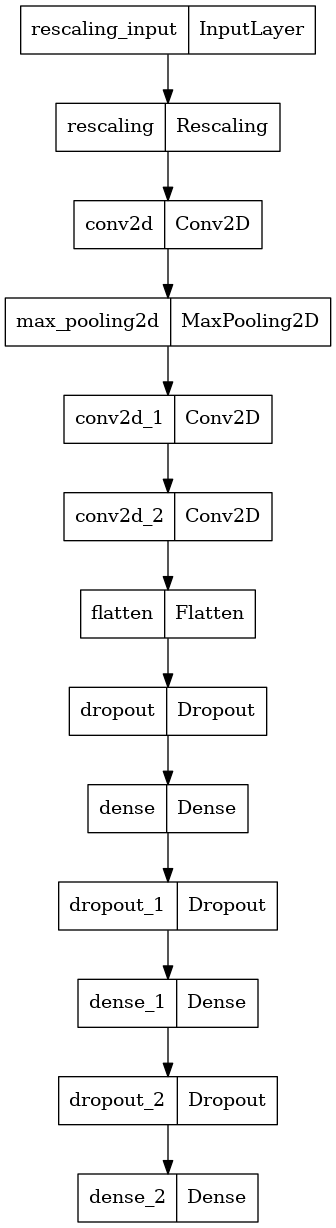

In [33]:
plot_model(model)

In [34]:
lmao = model.history

In [35]:
acc = fit.history['accuracy']
val_acc = fit.history['val_accuracy']
loss = fit.history['loss']
val_loss = fit.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.figure()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.title('Training and Validaion Loss')
plt.figure()

NameError: name 'fit' is not defined

In [37]:
model.save('./models/cnn-' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.keras')